## Sentinel-2 crop

In [1]:
service = dict([('title', 'S2 CROP'),
                ('abstract', 'Sentinel-2 crop'),
                ('id', 's22_crop')])

In [2]:
wkt =  dict([('id', 'AOI'),
             ('value', 'POLYGON((-6.79440295589744 37.1191319871777,-6.80827154725944 37.1673031942056,-6.72121114356795 37.2425767108835,-6.71042775152577 37.2930498879682,-6.73405462341917 37.3301447063348,-6.71685147187095 37.3522253716156,-6.67435624435345 37.3534492963332,-6.64461873043217 37.3365633914571,-6.62625336367183 37.3569789562915,-6.59581018720718 37.3506994424118,-6.58125246058411 37.3703051383248,-6.492413660497 37.3590379521576,-6.4716624422663 37.3807359777278,-6.43859705183134 37.368908852933,-6.44398095303713 37.347088527492,-6.42200724935979 37.3329929700694,-6.37035012694059 37.3583637388823,-6.33153540861988 37.3329986280188,-6.25703879672152 37.3486795386779,-6.2123425985781 37.3266608721382,-6.1976208676784 37.283024780795,-6.17366048732846 37.2660742144794,-6.15177710683581 37.2667431439207,-6.14475916204647 37.3055642119627,-6.1153577846492 37.3105672777454,-6.04475036124726 37.2771976083931,-6.04063041298302 37.2060457158668,-6.01561413928283 37.1744528799079,-6.03401959555254 37.1582677514823,-6.01528760169561 37.1211642619874,-6.03587498721126 37.0508366627984,-6.08415258431292 37.0557470251154,-6.1443715598251 37.0182321851901,-6.20489081698833 36.9013662293736,-6.24848183495607 36.8846441975983,-6.28133674315331 36.9000390906331,-6.27285487885334 36.8641095189495,-6.21240564569216 36.8569441225281,-6.19273049982008 36.8273222937041,-6.23650318117893 36.7815132843624,-6.25972339425557 36.7794168824025,-6.29452828553456 36.7134050019461,-6.32211152509425 36.693679078589,-6.40354402587554 36.7535989999008,-6.39366914786855 36.7750231637474,-6.42465019950879 36.7928589511795,-6.48913510482893 36.9063367348853,-6.55574132052792 36.9640015939793,-6.54729285159512 36.9812830814621,-6.79440295589744 37.1191319871777))'),
             ('title', 'Area of interest'),
             ('abstract', 'Area of interest in WKT')])

In [3]:
pa_code = dict([('id', 'pa_code'),
               ('value', 'DO'),
               ('title', 'Protected Area code'),
               ('abstract', 'Protected Area code (one of DO,...)')])

In [4]:
pa_name = dict([('id', 'pa_name'),
               ('value', 'Donana'),
               ('title', 'Protected Area name'),
               ('abstract', 'Protected Area name (one of Donana,...)')])

In [5]:
data_path = '/workspace/data'

In [6]:
input_identifier = 'S2A_MSIL1C_20170909T110651_N0205_R137_T30STF_20170909T111217'

In [7]:
input_reference = 'https://catalog.terradue.com/sentinel2/search?uid=S2A_MSIL1C_20170909T110651_N0205_R137_T30STF_20170909T111217'

In [8]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import snappy
import dateutil.parser as parser
import gc
from datetime import datetime
import matplotlib
import matplotlib.colors as colors

from os.path import basename
import gdal
import osr

%matplotlib inline

In [9]:
import sys

sys.path.append('/application/notebook/libexec/') 
sys.path.append(os.getcwd())
import ISOMetadata

In [10]:
s2prd = "%s/%s/%s.SAFE/MTD_MSIL1C.xml" % (data_path, input_identifier, input_identifier)
product = snappy.ProductIO.readProduct(s2prd)

width = product.getSceneRasterWidth()
height = product.getSceneRasterHeight()
name = product.getName()
description = product.getDescription()
band_names = product.getBandNames()



In [11]:
product_date = parser.parse(product.getStartTime().toString()).date()

In [12]:
output_date = '%s%02d%02d' % (product_date.year, product_date.month, product_date.day)

### Cloud coverage analysis over the cropped area

In [13]:
snappy.GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()

HashMap = snappy.jpy.get_type('java.util.HashMap')

WKTReader = snappy.jpy.get_type('com.vividsolutions.jts.io.WKTReader')
    
parameters = HashMap()
parameters.put('referenceBand', 'B1')
    
product = snappy.GPF.createProduct('Resample', parameters, product)

In [14]:
HashMap = snappy.jpy.get_type('java.util.HashMap')

BandDescriptor = snappy.jpy.get_type('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor')

targetBand0 = BandDescriptor()
targetBand0.name = 'cloud_mask'
targetBand0.type = 'uint16'
targetBand0.expression = 'cirrus_clouds_60m or opaque_clouds_60m'


targetBands = snappy.jpy.array('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor', 1)
targetBands[0] = targetBand0

 
parameters = HashMap()
parameters.put('targetBands', targetBands)

cloud_mask = snappy.GPF.createProduct('BandMaths', parameters, product)

In [15]:
WKTReader = snappy.jpy.get_type('com.vividsolutions.jts.io.WKTReader')
geom = WKTReader().read(wkt['value'])


parameters = HashMap()
parameters.put('copyMetadata', True)
parameters.put('geoRegion', geom)
    
cloud_mask_geo = snappy.GPF.createProduct('Subset', parameters, cloud_mask)
mask_output_name = 'S2A_USER_PRD_MSIL1C_%s_%s_MASK_%s.tif' % (output_date, pa_code['value'], '60')
snappy.ProductIO.writeProduct(cloud_mask_geo, mask_output_name, 'GeoTIFF')

In [16]:
import gdalnumeric
raster_file = gdalnumeric.LoadFile(mask_output_name)
pixel_count_cloud = (raster_file == 1).sum()  # for pixel value = 1

cloud_percent =  float(pixel_count_cloud) / float(raster_file.size) * 100.0

In [17]:
cloud_percent

99.87594992691832

In [ ]:
cloud_mask = None
cloud_mask_geo = None
raster_file = None

gc.collect()

### Crop

In [18]:
snappy.GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()

HashMap = snappy.jpy.get_type('java.util.HashMap')

WKTReader = snappy.jpy.get_type('com.vividsolutions.jts.io.WKTReader')
geom = WKTReader().read(wkt['value'])

subsets = []
geotiffs = []
for band in list(band_names)[0:13]:
    
    parameters = HashMap()
    parameters.put('referenceBand', band)
    
    resample = snappy.GPF.createProduct('Resample', parameters, product)

    parameters = HashMap()
    parameters.put('copyMetadata', True)
    parameters.put('sourceBands', band)
   
    subset = snappy.GPF.createProduct('Subset', parameters, resample)
    
    parameters = HashMap()
    parameters.put('copyMetadata', True)
    parameters.put('geoRegion', geom)
    
    subset_geo = snappy.GPF.createProduct('Subset', parameters, subset)
    
    subsets.append(subset_geo)
    
    output_name = 'S2A_USER_PRD_MSIL1C_%s_%s_CROP_%s.tif' % (output_date, pa_code['value'], band)
    geotiffs.append(output_name)
    
    snappy.ProductIO.writeProduct(subset_geo, output_name, 'GeoTIFF')

In [19]:
%matplotlib inline

def plotBand(product, band, vmin, vmax):
     
    band = product.getBand(band)

    w = band.getRasterWidth()
    h = band.getRasterHeight()

    band_data = np.zeros(w * h, np.float32)
    band.readPixels(0, 0, w, h, band_data)

    band_data.shape = h, w

    imgplot = plt.imshow(band_data, cmap=plt.cm.binary_r, vmin=vmin, vmax=vmax)

    
    return imgplot 


KeyboardInterrupt: 

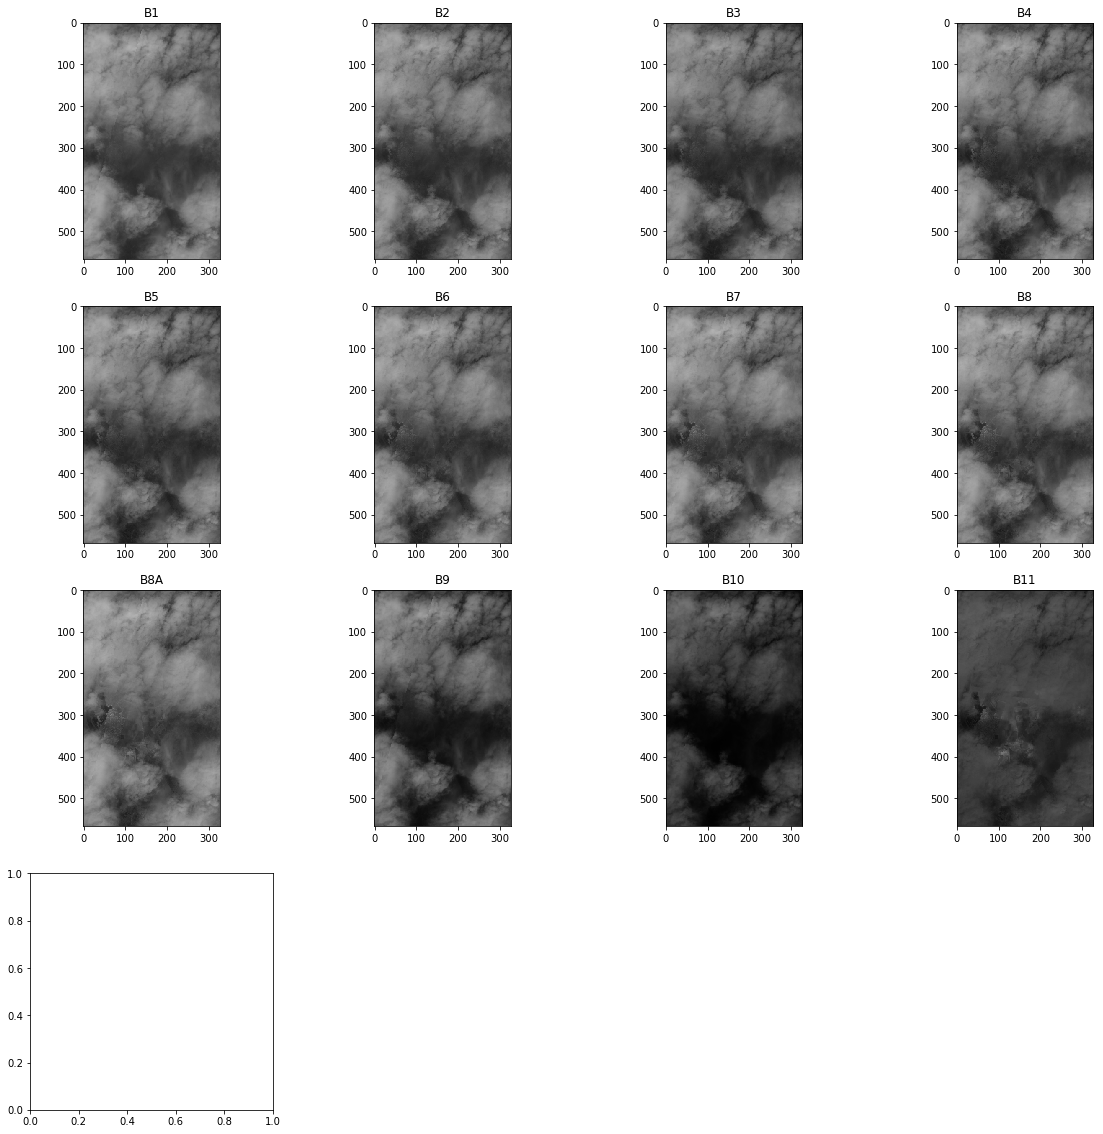

In [20]:
if False:
    fig = plt.figure(figsize=(20,20))

    for index, subset in enumerate(subsets):
        a=fig.add_subplot(4,4,index+1)
        imgplot = plotBand(subset, subsets[index].getBandNames()[0], 0, 1)
        name = subsets[index].getBandNames()[0]
        a.set_title(name)
    
    plt.tight_layout()
    fig = plt.gcf() 
    plt.show()

    fig.clf()
    plt.close()
    gc.collect()

In [ ]:
def set_dates():
    
    iso_metadata.set_start_date(parser.parse(subset.getStartTime().toString()).isoformat())
    iso_metadata.set_end_date(parser.parse(subset.getEndTime().toString()).isoformat())

In [ ]:
def set_info():
    
    short_name = os.path.splitext(basename(geotiff))[0]
    
    iso_metadata.set_identifier(short_name)
    band = 'B1'
    iso_metadata.set_title('Sentinel 2 Level 1C Band %s' % band)
    iso_metadata.set_abstract('Sentinel 2 Level 1C Top of Atmosphere Reflectance for Band %s' % band)

In [ ]:
def set_geo():
    
    ds = gdal.Open(geotiff)

    iso_metadata.set_col_size(str(ds.RasterXSize))
    iso_metadata.set_row_size(str(ds.RasterYSize))

    transform = ds.GetGeoTransform()

    iso_metadata.set_pixel_size(str(transform[1]))

    ul_x = transform[0]
    ul_y = transform[3]

    nw_corner = '%s %s' % (str(ul_x), str(ul_y))

    iso_metadata.set_nw_corner(nw_corner)

    lr_x = transform[0] + transform[1] * ds.RasterXSize
    lr_y = transform[3] + transform[5] * ds.RasterYSize

    se_corner = '%s %s' % (str(lr_x), str(lr_y))

    iso_metadata.set_se_corner(se_corner)

    
    
    old_cs= osr.SpatialReference()
    old_cs.ImportFromWkt(ds.GetProjectionRef())

    wgs84_wkt = """
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.01745329251994328,
        AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]]"""
    new_cs = osr.SpatialReference()
    new_cs .ImportFromWkt(wgs84_wkt)

    transform = osr.CoordinateTransformation(old_cs,new_cs) 

    min_lon = transform.TransformPoint(ul_x,lr_y)[0]
    iso_metadata.set_min_lon(str(min_lon))

    min_lat = transform.TransformPoint(ul_x,lr_y)[1]
    iso_metadata.set_min_lat(str(min_lat))

    max_lon = transform.TransformPoint(lr_x, ul_y)[0]
    iso_metadata.set_max_lon(str(max_lon))

    max_lat = transform.TransformPoint(lr_x, ul_y)[1]
    iso_metadata.set_max_lat(str(max_lat))
    
    prj = ds.GetProjection()
    srs=osr.SpatialReference(wkt=prj)


    iso_metadata.set_epsg_code(srs.GetAttrValue("PROJCS|AUTHORITY", 1))

In [ ]:
def write_properties(properties_file):
    
    properties = open(properties_file + '.properties', 'w')

    properties.write('identifier=' + geotiff)
    properties.write('\n')
    properties.write('date=%s/%s' % (parser.parse(subset.getStartTime().toString()).isoformat(), 
                                 parser.parse(subset.getEndTime().toString()).isoformat()))
    properties.write('\n')
    properties.write('category=%s,http://www.terradue.com/api/data-pipeline/results,%s Protected Area resource' % (pa_code, pa_name))
 
    properties.close()

In [ ]:
iso_metadata = ISOMetadata.ISOMetadata()

In [ ]:
iso_metadata.set_contact('info@terradue.com')
iso_metadata.set_date(output_date)
iso_metadata.set_data_format('GEOTIFF')
iso_metadata.set_data_type('UInt16')
iso_metadata.set_pa(pa_name)
iso_metadata.set_data_quality('Nominal')
iso_metadata.set_responsible_party('CNR')

In [ ]:
for index, geotiff in enumerate(geotiffs):

    subset = subsets[index] 
    
    set_dates()
    
    set_info()
    
    set_geo()
    
    iso_metadata.write(os.path.splitext(basename(geotiff))[0] + '.xml')
    
    write_properties(basename(geotiff))